In [ ]:
!pip install tensorflow==2.8.0 tensorflow-gpu==2.8.0 tf_bodypix opencv-python tfjs_graph_converter matplotlib

#Load model

In [ ]:
import cv2
import tfjs_graph_converter
import tensorflow as tf
from tf_bodypix.api import load_model, download_model, BodyPixModelPaths
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
bp_model = load_model(download_model(BodyPixModelPaths.MOBILENET_FLOAT_50_STRIDE_16))

#Capture photo

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

#Show photo

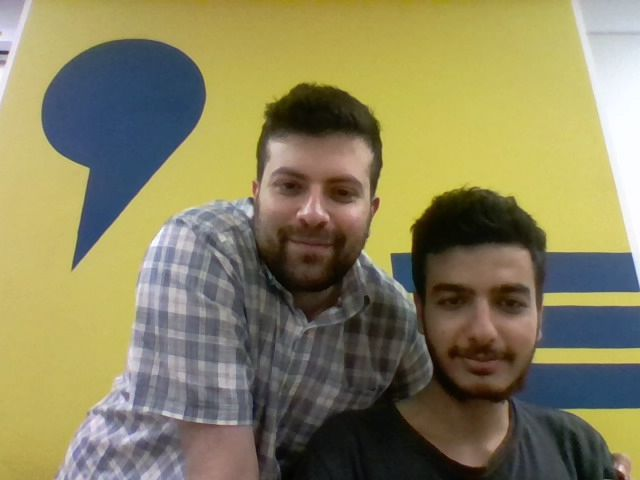

-1

In [ ]:
from google.colab.patches import cv2_imshow

image = cv2.imread("photo.jpg")
cv2_imshow(image)
cv2.waitKey(0)

#Masking human

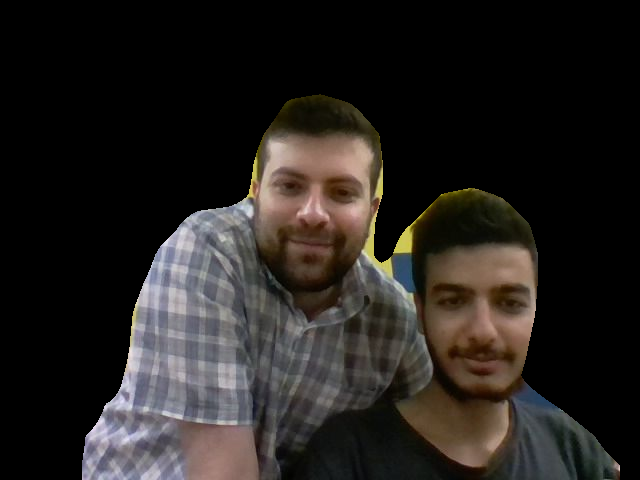

-1

In [ ]:
from google.colab.patches import cv2_imshow

image = cv2.imread("photo.jpg") #Reading the image

prediction = bp_model.predict_single(image) # Passing the image to the model
mask = prediction.get_mask(threshold=0.55).numpy().astype(np.uint8)
new_mask = cv2.bitwise_and(image, image, mask=mask)

cv2_imshow(new_mask)
cv2.waitKey(0)

In [ ]:
image.shape

(480, 640, 3)

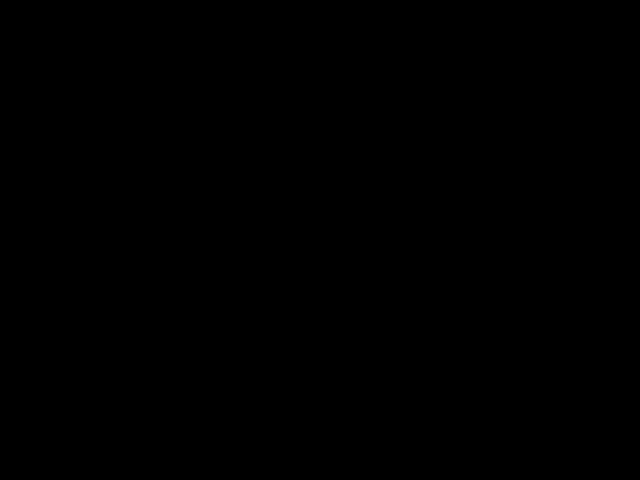

In [ ]:
negative = np.add(mask, -1)
cv2_imshow(negative)

In [ ]:
negative.shape

(480, 640, 1)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab.patches import cv2_imshow

img = cv2.imread("/content/drive/MyDrive/Datasets/IMG_0090.WEBP")
cv2_imshow(img)
cv2.waitKey(0)

In [ ]:
img.shape

(720, 1280, 3)

In [ ]:
img = cv2.resize(img, (640, 480), interpolation = cv2.INTER_AREA)

In [ ]:
img.shape

(480, 640, 3)

In [ ]:
cv2_imshow(img)

In [ ]:
inverse = np.where(negative==-1, 1, negative).astype(np.uint8)
masked_bg = cv2.bitwise_and(img, img, mask=inverse)

cv2_imshow(masked_bg)

In [ ]:
final_image = cv2.add(new_mask, masked_bg)

cv2_imshow(final_image)

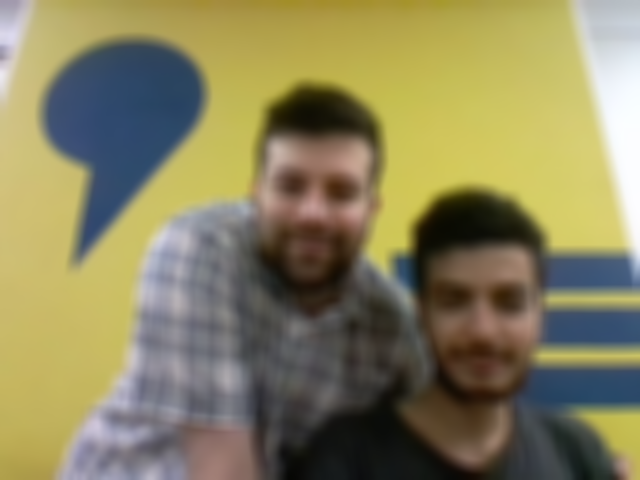

In [ ]:
img = cv2.imread("photo.jpg")

img = cv2.blur(img, (15, 15))

cv2_imshow(img)

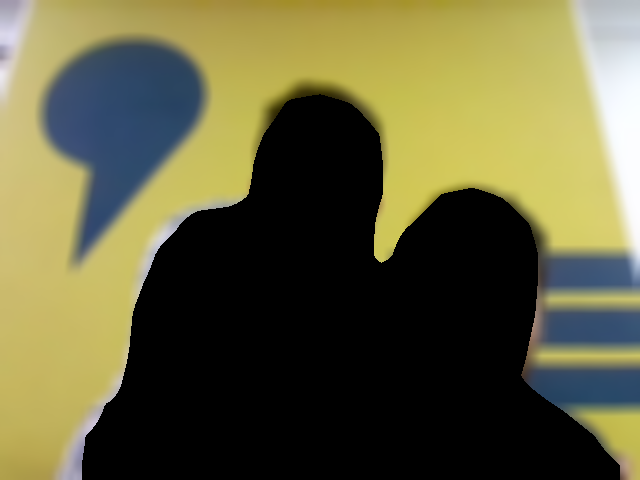

In [ ]:
inverse = np.where(negative==-1, 1, negative).astype(np.uint8)
masked_bg = cv2.bitwise_and(img, img, mask=inverse)

cv2_imshow(masked_bg)

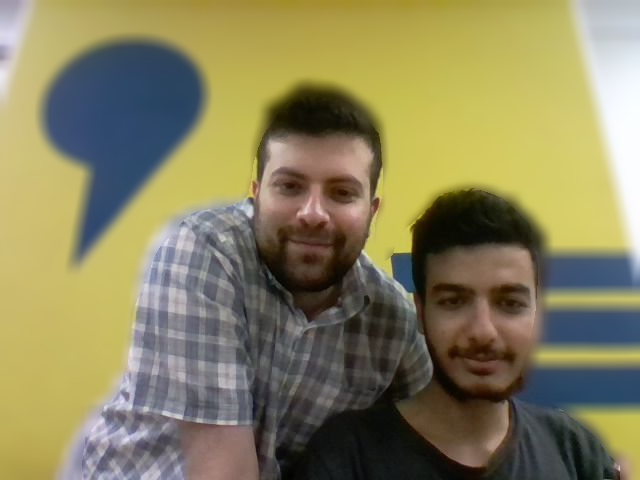

In [ ]:
final_image = cv2.add(new_mask, masked_bg)

cv2_imshow(final_image)

In [ ]:
from IPython.display import display, Javascript,HTML
from google.colab.output import eval_js
from base64 import b64decode
 
def record_video(filename):
  js=Javascript("""
    async function recordVideo() {
      const options = { mimeType: "video/webm; codecs=vp9" };
      const div = document.createElement('div');
      const capture = document.createElement('button');
      const stopCapture = document.createElement("button");
       
      capture.textContent = "Start Recording";
      capture.style.background = "orange";
      capture.style.color = "white";
 
      stopCapture.textContent = "Stop Recording";
      stopCapture.style.background = "red";
      stopCapture.style.color = "white";
      div.appendChild(capture);
 
      const video = document.createElement('video');
      const recordingVid = document.createElement("video");
      video.style.display = 'block';
 
      const stream = await navigator.mediaDevices.getUserMedia({audio:true, video: true});
     
      let recorder = new MediaRecorder(stream, options);
      document.body.appendChild(div);
      div.appendChild(video);
 
      video.srcObject = stream;
      video.muted = true;
 
      await video.play();
 
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
 
      await new Promise((resolve) => {
        capture.onclick = resolve;
      });
      recorder.start();
      capture.replaceWith(stopCapture);
 
      await new Promise((resolve) => stopCapture.onclick = resolve);
      recorder.stop();
      let recData = await new Promise((resolve) => recorder.ondataavailable = resolve);
      let arrBuff = await recData.data.arrayBuffer();
       
      stream.getVideoTracks()[0].stop();
      div.remove();
 
      let binaryString = "";
      let bytes = new Uint8Array(arrBuff);
      bytes.forEach((byte) => {
        binaryString += String.fromCharCode(byte);
      })
    return btoa(binaryString);
    }
  """)
  try:
    display(js)
    data=eval_js('recordVideo({})')
    binary=b64decode(data)
    with open(filename,"wb") as video_file:
      video_file.write(binary)
    print(f"Finished recording video at:{filename}")
  except Exception as err:
    print(str(err))

In [ ]:
video_path = "test.mp4"
record_video(video_path)

<IPython.core.display.Javascript object>

Finished recording video at:test.mp4


In [ ]:
from IPython.display import HTML
from base64 import b64encode
 
def show_video(video_path, video_width = 600):
   
  video_file = open(video_path, "r+b").read()
 
  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  return HTML(f"""<video width={video_width} controls><source src="{video_url}"></video>""")
 
show_video(video_path)

In [ ]:
import cv2
import os

vidcap = cv2.VideoCapture('test.mp4')
success,image = vidcap.read()

os.mkdir("./frames")
os.chdir("./frames")

count = 0
while success:
  cv2.imwrite("frame%d.jpg" % count, image)      
  success,image = vidcap.read()
  print('Read a new frame: ', success)
  count += 1

In [ ]:
def background_blur(directory):
  input_img_path = sorted([os.path.join(directory, fname)
    for fname in os.listdir(directory)
    if fname.endswith(".jpg")])

  os.chdir("/content")
  #os.mkdir("new_frames")
  os.chdir("new_frames")

  for i in range(len(input_img_path)):
    image = cv2.imread(input_img_path[i])
    prediction = bp_model.predict_single(image)
    mask = prediction.get_mask(threshold=0.55).numpy().astype(np.uint8)
    new_mask = cv2.bitwise_and(image, image, mask=mask)

    negative = np.add(mask, -1)
    img = cv2.imread(input_img_path[i])
    img = cv2.blur(img, (15, 15))
    inverse = np.where(negative==-1, 1, negative).astype(np.uint8)
    masked_bg = cv2.bitwise_and(img, img, mask=inverse)
    final_image = cv2.add(new_mask, masked_bg)

    cv2.imwrite("new_frame%d.jpg" % i, final_image)

    cv2.waitKey(0)

In [ ]:
background_blur("/content/frames")

In [ ]:
import cv2
import numpy as np
import glob

img_array = []
input_img_path = sorted([os.path.join("/content/new_frames", fname)
    for fname in os.listdir("/content/new_frames")
    if fname.endswith(".jpg")])
for filename in input_img_path:
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)


out = cv2.VideoWriter('project.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 15, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

In [ ]:
show_video("/content/new_frames/project.mp4")